# Steps of the Data Analysis of Astro

In [127]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.fft import fft, fftfreq, ifft
from scipy.signal import decimate

Reading and printing the Time Series (Observation of 10 seconds)

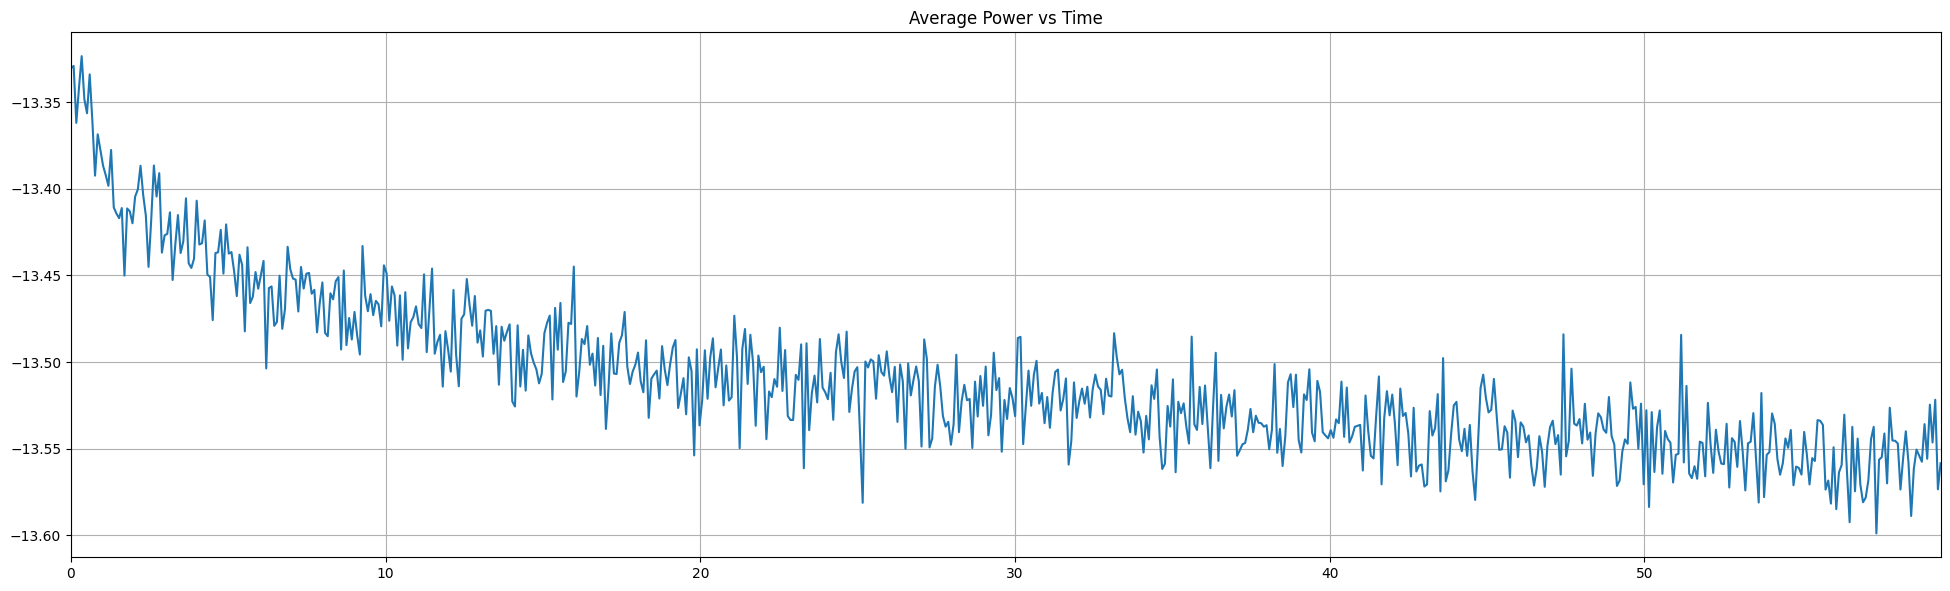

In [128]:
timeSeries = pd.read_csv('time_series.csv', names = ('Relative Time','Relative Power'))

fig = plt.figure(figsize=(27, 15))
gs = GridSpec(2, 3, width_ratios=[16.5, 1, 1])

ax4 = fig.add_subplot(gs[1, 0:2])
ax4.grid()
ax4.set_xlim(min(timeSeries['Relative Time']),max(timeSeries['Relative Time']))
ax4.plot(timeSeries['Relative Time'], timeSeries['Relative Power'], label='Raw Time Series')
ax4.set_title('Average Power vs Time')
print()

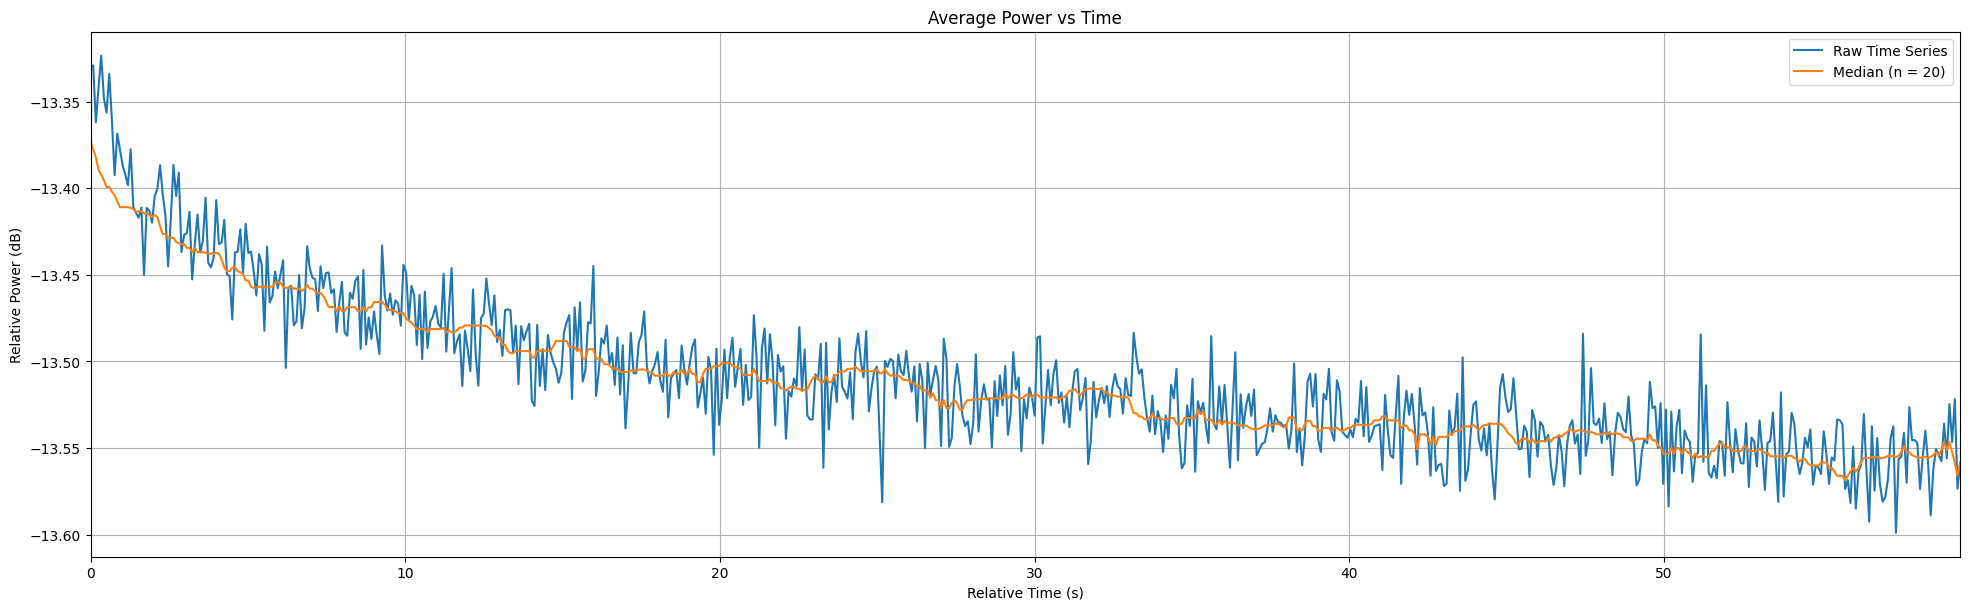

In [129]:
ax4.set_xlabel('Relative Time (s)')
ax4.set_ylabel('Relative Power (dB)')

N = sum(1 for column in timeSeries['Relative Power']) 
median_power = timeSeries['Relative Power'].copy()
for i in range(0, N):
			median_power[i] = np.nanmedian(median_power[i:i+20])
ax4.plot(timeSeries['Relative Time'], median_power, label='Median (n = 20)')
ax4.legend()

fig

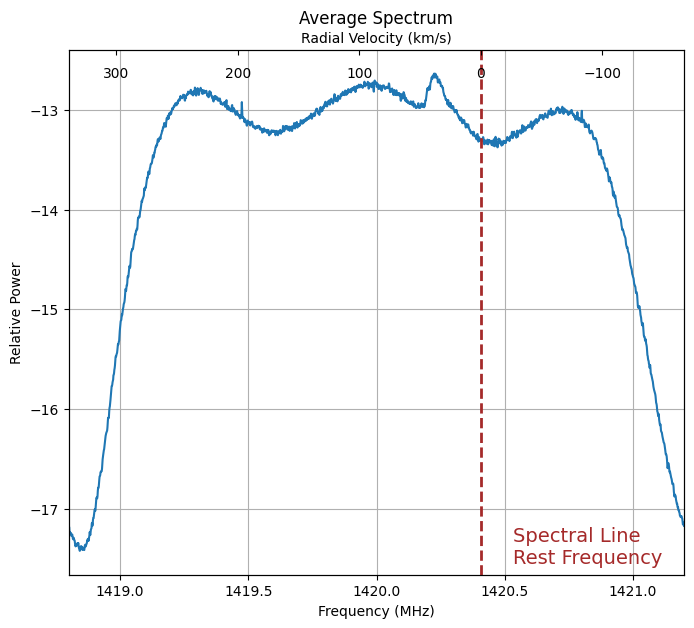

In [130]:
def decibel(x):
		if dB: return 10.0*np.log10(x)
		return 


timeStep = timeSeries['Relative Time'][1] - timeSeries['Relative Time'][0]
timeSample = 10
frequency = 1420*10**6
bandwidth = 2.4*10**6
channels = 2048
bins = timeStep*bandwidth/channels
dB = True

f_rest = 1420.405751768e6
left_velocity_edge = -299792.458*(bandwidth-2*frequency+2*f_rest)/(bandwidth-2*frequency)
right_velocity_edge = 299792.458*(-bandwidth-2*frequency+2*f_rest)/(bandwidth+2*frequency)

waterfall = np.fromfile('observation.dat', dtype='float32').reshape(-1, channels)/bins
waterfall = waterfall[3:,:]
avg_spectrum =  decibel(np.nanmean(waterfall, axis=0))
subs = waterfall.shape[0]
t = timeSample*np.arange(subs)
power = np.nanmean(waterfall, axis=1)
frequency = np.linspace(frequency-0.5*bandwidth, frequency+0.5*bandwidth,
	                        channels, endpoint=False)*1e-6


waterfall_cal = np.fromfile('calibration.dat', dtype='float32').reshape(-1, channels)/bins
waterfall_cal = waterfall_cal[3:, :]
avg_spectrum_cal = decibel(np.nanmean(waterfall_cal, axis=0))

gs = GridSpec(2,3)
ax1 = fig.add_subplot(gs[0, 0])
ax1.set_xlim(np.min(frequency), np.max(frequency))
ax1.set_xlabel('Frequency (MHz)')
ax1.set_ylabel('Relative Power')
ax1.set_title('Average Spectrum')
ax1.grid()
ax1.plot(frequency, avg_spectrum)

ax1_secondary = ax1.twiny()
ax1_secondary.set_xlabel('Radial Velocity (km/s)', labelpad=5)
ax1_secondary.axvline(x=0, color='brown', linestyle='--', linewidth=2, zorder=0)
ax1_secondary.annotate('Spectral Line\nRest Frequency', xy=(320, 5),
                               xycoords='axes points', size=14, ha='left', va='bottom', color='brown')
ax1_secondary.set_xlim(left_velocity_edge, right_velocity_edge)
ax1_secondary.tick_params(axis='x', direction='in', pad=-22)

ax4.remove()
fig


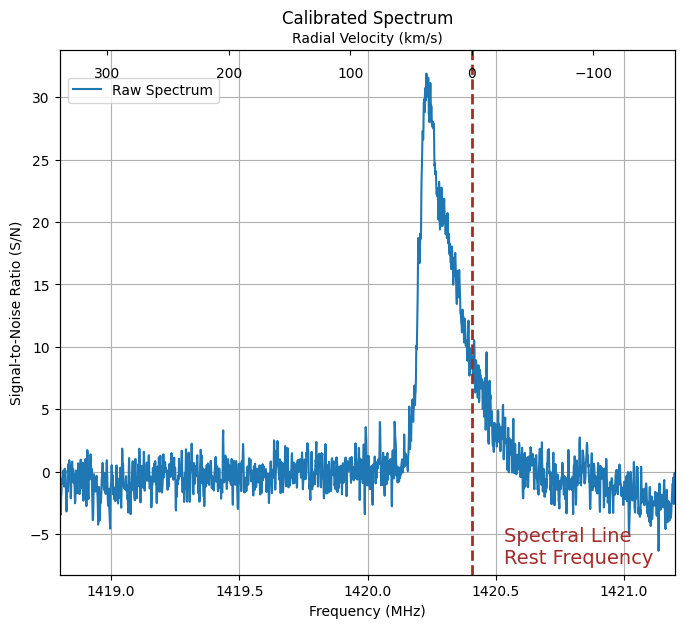

In [131]:
def SNR(spectrum, mask=np.array([])):
	if mask.size == 0:
		mask = np.zeros_like(spectrum)
	noise = np.nanstd((spectrum[2:]-spectrum[:-2])[mask[1:-1] == 0])/np.sqrt(2)
	background = np.nanmean(spectrum[mask == 0])		
	return (spectrum-background)/noise

if dB:
	spectrum = 10**((avg_spectrum-avg_spectrum_cal)/10)
else:
	spectrum = avg_spectrum/avg_spectrum_cal

mask = np.zeros_like(avg_spectrum)
mask[np.logical_and(frequency > f_rest*1e-6-0.2, frequency < f_rest*1e-6+0.8)] = 1
spectrum = SNR(spectrum, mask)

ax2 = fig.add_subplot(gs[0, 1])
ax2.set_xlim(np.min(frequency), np.max(frequency))
ax2.ticklabel_format(useOffset=False)
ax2.set_xlabel('Frequency (MHz)')
ax2.set_ylabel('Signal-to-Noise Ratio (S/N)')
ax2.grid()
ax2.set_title('Calibrated Spectrum')
ax2.plot(frequency, spectrum, label='Raw Spectrum')
ax2.legend(bbox_to_anchor=(0.002, 0.96), loc='upper left')
ax1.remove()

ax2_secondary = ax2.twiny()
ax2_secondary.set_xlabel('Radial Velocity (km/s)', labelpad=5)
ax2_secondary.axvline(x=0, color='brown', linestyle='--', linewidth=2, zorder=0)
ax2_secondary.annotate('Spectral Line\nRest Frequency', xy=(320, 5),
                                   xycoords='axes points', size=14, ha='left', va='bottom', color='brown')
ax2_secondary.set_xlim(left_velocity_edge, right_velocity_edge)
ax2_secondary.tick_params(axis='x', direction='in', pad=-22)

ax1_secondary.remove()
fig

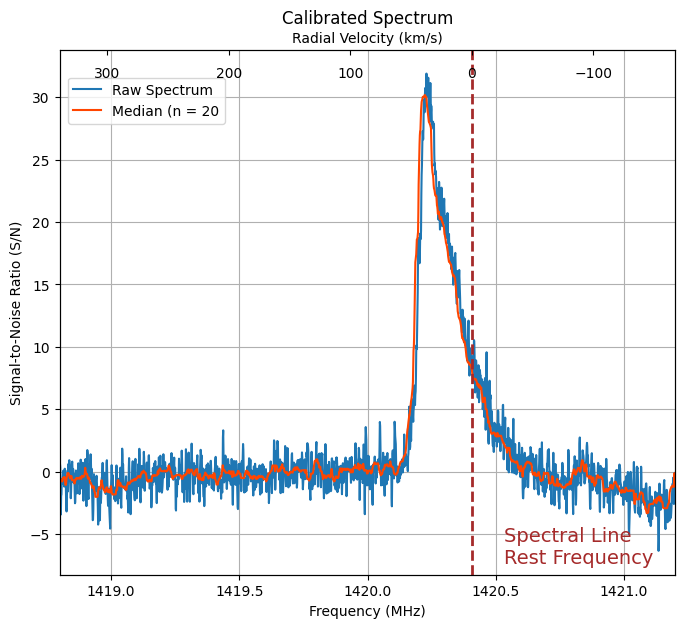

In [132]:
spectrum_clean = SNR(spectrum.copy(), mask)
for i in range(0, int(channels)):
	spectrum_clean[i] = np.nanmedian(spectrum_clean[i:i+20])
	

ax2.plot(frequency, spectrum_clean, color='orangered', label='Median (n = '+str(20))
ax2.legend(bbox_to_anchor=(0.002, 0.96), loc='upper left')
fig

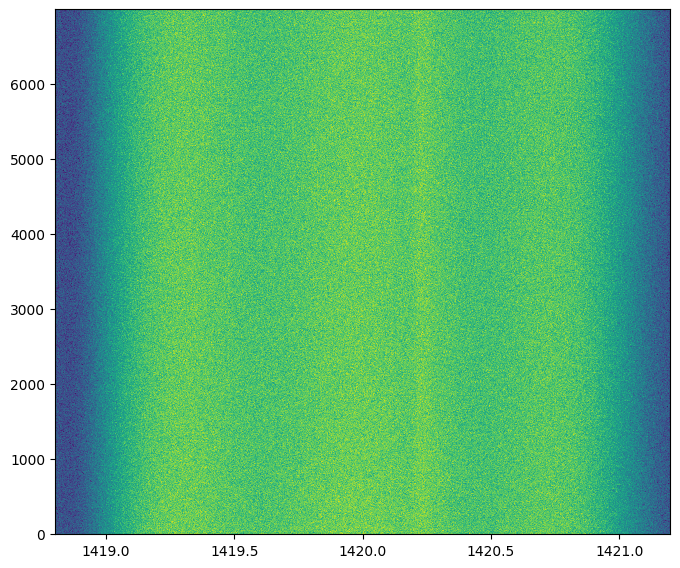

In [133]:
ax3 = fig.add_subplot(gs[0, 2])
ax3.imshow(decibel(waterfall), origin='lower', interpolation='None', aspect='auto',
		   extent=[np.min(frequency), np.max(frequency), np.min(t), np.max(t)])
ax2.remove()
ax2_secondary.remove()
fig

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


1418.8
1421.1988281249999
2.398828124999909


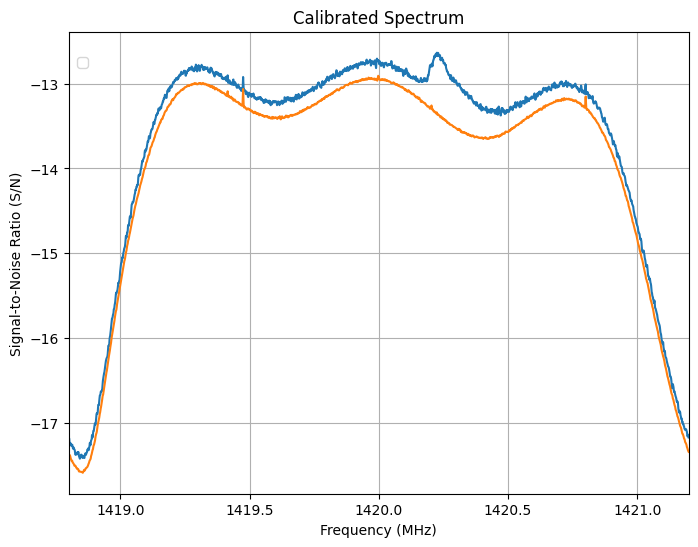

In [134]:
plt.figure(figsize=(8,6))
plt.xlim(np.min(frequency), np.max(frequency))
plt.ticklabel_format(useOffset=False)
plt.xlabel('Frequency (MHz)')
plt.ylabel('Signal-to-Noise Ratio (S/N)')
plt.grid()
plt.title('Calibrated Spectrum')
plt.legend(bbox_to_anchor=(0.002, 0.96), loc='upper left')
plt.plot(frequency, avg_spectrum, label='Raw')
plt.plot(frequency, avg_spectrum_cal, label='Clean')
print(min(frequency))
print(max(frequency))
print(max(frequency)-min(frequency))


C:\Users\Tzagkari\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


0.04352278545826933

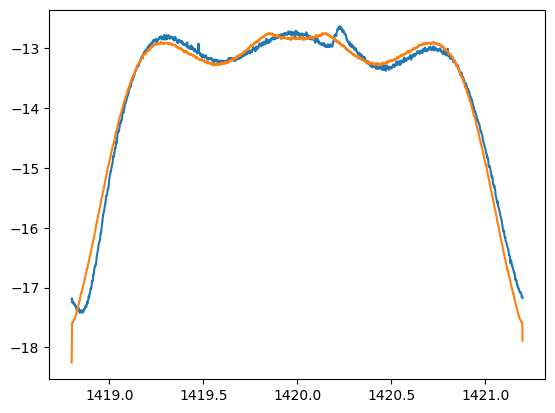

In [146]:
y = fft(avg_spectrum)
a = y.real
b = y.imag
y = y.real*y.real+y.imag*y.imag
y = -np.sqrt(np.abs(y))
y = ifft(y)

decimation = 1953
fy = timeStep*10**3
fy = fy/decimation
fnyq = fy/2
stopband = 40
passband = 1

filtered = decimate(y, decimation)
cal = (avg_spectrum/y)
plt.plot(frequency, avg_spectrum)
plt.plot(frequency, y)
#plt.plot(frequency, filtered)

fy